# 2015 NYC Street Tree Census
Determining the Health of Trees in New York City Neighborhoods

Alt title: TreesCount! 2015-2016 Street Tree Census

Brief: TreesCount! 2015 is a volunteer-powered campaign to map, count, and care for all of New York City’s street trees.


## Introduction
This project is a exploratory data analysis with python of the 2015 New York City Street Tree Census dataset that is available on NYC Open Data. The analysis explores the species, health, size, and geolocation of trees living on NYC streets. The project identifies the most common tree species and using `geopandas` plots their geolocation on a map of New York City's five boroughs.

<b>Dataset Description:</b> TreesCount! 2015-2016, the New York City Department of Parks & Recreation's third street tree census, brought more than 2,200 volunteers together in the largest participatory municipal urban forestry project in United States history. Using both high tech tools and survey wheels, tape measures, and tree identification keys, citizen mappers helped to create a spatially accurate digital inventory of NYC’s street trees.


> data source: https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh

Dataset Resources:
> How the Tree Census Works: https://www.nycgovparks.org/trees/treescount/about

> 2015 Trees Count Manual: https://www.nycgovparks.org/pagefiles/116/trees-count-2015-training__592dcbad8488f.pdf

NYC Borough Boundaries shape file source:
https://data.cityofnewyork.us/City-Government/Borough-Boundaries/qefp-jxjk

## Questions

* How many unique species of trees are there on NYC streets? What are the most common species?
* What is the health of trees on NYC streets?
* How big are trees on NYC streets? 
* Where are trees located in the five boroughs?



## Prepare Data
### Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform

import geopandas as gpd
from shapely.geometry import Point, Polygon

### Open local csv files
Read the local copy of the data downloaded from NYC Open Data
`2015_Street_Tree_Census_-_Tree_Data.csv`

In [2]:
path = "../data/2015_Street_Tree_Census_-_Tree_Data.csv"
df = pd.read_csv(path)
df.head()

tree_id  block_id  created_at  tree_dbh  stump_diam curb_loc status health  \
0   180683    348711  08/27/2015         3           0   OnCurb  Alive   Fair   
1   200540    315986  09/03/2015        21           0   OnCurb  Alive   Fair   
2   204026    218365  09/05/2015         3           0   OnCurb  Alive   Good   
3   204337    217969  09/05/2015        10           0   OnCurb  Alive   Good   
4   189565    223043  08/30/2015        21           0   OnCurb  Alive   Good   

                            spc_latin       spc_common  ...  boro_ct  \
0                         Acer rubrum        red maple  ...  4073900   
1                   Quercus palustris          pin oak  ...  4097300   
2  Gleditsia triacanthos var. inermis      honeylocust  ...  3044900   
3  Gleditsia triacanthos var. inermis      honeylocust  ...  3044900   
4                     Tilia americana  American linden  ...  3016500   

      state   latitude  longitude         x_sp         y_sp council district  \
0  New York  40.723092 -73.844215  1027431.148  202756.7687             29.0   
1  New York  40.794111 -73.818679  1034455.701  228644.8374             19.0   
2  New York  40.717581 -73.936608  1001822.831  200716.8913             34.0   
3  New York  40.713537 -73.934456  1002420.358  199244.2531             34.0   
4  New York  40.666778 -73.975979   990913.775  182202.4260             39.0   

  census tract        bin           bbl  
0        739.0  4052307.0  4.022210e+09  
1        973.0  4101931.0  4.044750e+09  
2        449.0  3338310.0  3.028870e+09  
3        449.0  3338342.0  3.029250e+09  
4        165.0  3025654.0  3.010850e+09  

[5 rows x 45 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 45 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tree_id           683788 non-null  int64  
 1   block_id          683788 non-null  int64  
 2   created_at        683788 non-null  object 
 3   tree_dbh          683788 non-null  int64  
 4   stump_diam        683788 non-null  int64  
 5   curb_loc          683788 non-null  object 
 6   status            683788 non-null  object 
 7   health            652172 non-null  object 
 8   spc_latin         652169 non-null  object 
 9   spc_common        652169 non-null  object 
 10  steward           652173 non-null  object 
 11  guards            652172 non-null  object 
 12  sidewalk          652172 non-null  object 
 13  user_type         683788 non-null  object 
 14  problems          652124 non-null  object 
 15  root_stone        683788 non-null  object 
 16  root_grate        68

### Clean Data

In [4]:
# make common species names title case
df.spc_common = [df.spc_common[i].title() if v == False else df.spc_common[i] for i, v in enumerate(df.spc_common.isna())]

In [5]:
# where status is not 'alive' fill health with 'dead'
df['health'] = ['Dead' if df.status[i] != 'Alive' else h for i, h in enumerate(df.health)]

In [6]:
# drop rows where health is empty 
df.dropna(subset=['health'], axis=0, inplace=True)

### Select Data

In [7]:
variables = ['tree_dbh', 'status', 'health', 'spc_common', 'borough', 'latitude', 'longitude']
df = df[variables]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683787 entries, 0 to 683787
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   tree_dbh    683787 non-null  int64  
 1   status      683787 non-null  object 
 2   health      683787 non-null  object 
 3   spc_common  652168 non-null  object 
 4   borough     683787 non-null  object 
 5   latitude    683787 non-null  float64
 6   longitude   683787 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 41.7+ MB


## Analysis

### Tree Species
How many unique species of trees are living on NYC streets? What are the most common species overall and by borough?

#### Method
Let's use common species names from `spc_common` to calculate the normalized value counts of each unique species. We'll count the length of the species list to get our count of unique species, then plot a bar chart to visualize the proportion of the top 10 most common tree species overall and by `borough`.

In [8]:
# normalize tree counts by tree species
species_counts = df.spc_common.value_counts(dropna=True, normalize=True).reset_index()
species_counts.columns = ["species", "proportion"]
top_species = species_counts[:10]
display(top_species)

species  proportion
0   London Planetree    0.133423
1        Honeylocust    0.098539
2       Callery Pear    0.090362
3            Pin Oak    0.081551
4       Norway Maple    0.052424
5  Littleleaf Linden    0.045605
6             Cherry    0.044895
7   Japanese Zelkova    0.044863
8             Ginkgo    0.032237
9            Sophora    0.029652

In [9]:
# normalize tree counts by tree species in each borough
species_counts_boro = []
for b in df.borough.unique().tolist():
    counts = df[df.borough==b].spc_common.value_counts(dropna=True, normalize=True).reset_index()
    counts.columns = ["species", "proportion"]
    species_counts_boro.append(counts)
    print(b)
    display(counts[:10])

Queens


species  proportion
0   London Planetree    0.130735
1            Pin Oak    0.095012
2        Honeylocust    0.085263
3       Norway Maple    0.081552
4       Callery Pear    0.069534
5             Cherry    0.056717
6  Littleleaf Linden    0.050015
7   Japanese Zelkova    0.037765
8          Green Ash    0.031050
9       Silver Maple    0.025701

Brooklyn


species  proportion
0   London Planetree    0.205521
1        Honeylocust    0.099685
2            Pin Oak    0.072715
3   Japanese Zelkova    0.056903
4       Callery Pear    0.053498
5  Littleleaf Linden    0.052450
6       Norway Maple    0.041174
7            Sophora    0.035283
8             Cherry    0.033615
9             Ginkgo    0.032961

Manhattan


species  proportion
0        Honeylocust    0.211059
1       Callery Pear    0.116887
2             Ginkgo    0.093852
3            Pin Oak    0.073429
4            Sophora    0.071330
5   London Planetree    0.066028
6   Japanese Zelkova    0.057602
7  Littleleaf Linden    0.053390
8       American Elm    0.027199
9    American Linden    0.025357

Staten Island


species  proportion
0      Callery Pear    0.207596
1  London Planetree    0.092506
2         Red Maple    0.072682
3           Pin Oak    0.071006
4            Cherry    0.050423
5          Sweetgum    0.049388
6       Honeylocust    0.041265
7      Norway Maple    0.040683
8      Silver Maple    0.039954
9             Maple    0.025739

Bronx


species  proportion
0        Honeylocust    0.120260
1   London Planetree    0.093207
2            Pin Oak    0.079979
3       Callery Pear    0.061389
4   Japanese Zelkova    0.057555
5             Cherry    0.050779
6  Littleleaf Linden    0.048608
7       Norway Maple    0.041894
8             Ginkgo    0.033319
9            Sophora    0.031706

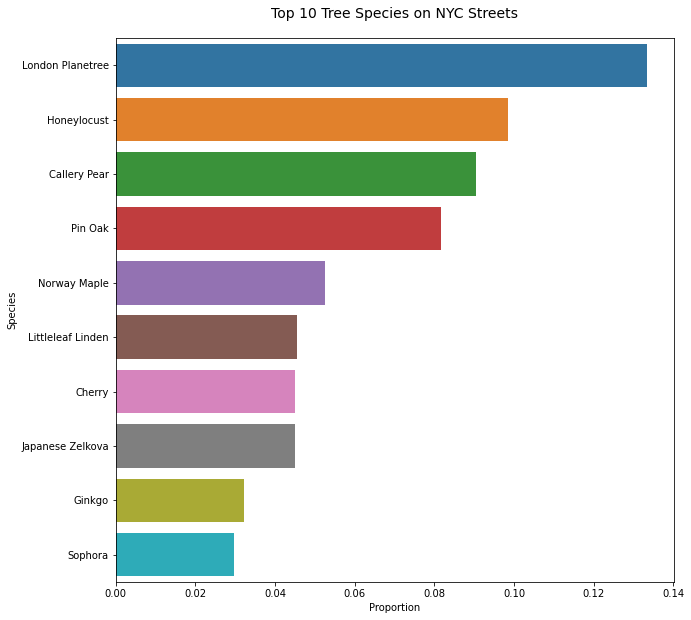

In [10]:
display_top = 10
plt.figure(figsize=(10,10))
ax=plt.subplot()
sns.barplot(data=species_counts[:display_top].sort_values(by='proportion', ascending=False), x='proportion', y='species', palette='tab10')
plt.title('Top {} Tree Species on NYC Streets'.format(display_top), fontsize=14, pad=20)
plt.ylabel('Species')
plt.xlabel('Proportion')
plt.show()

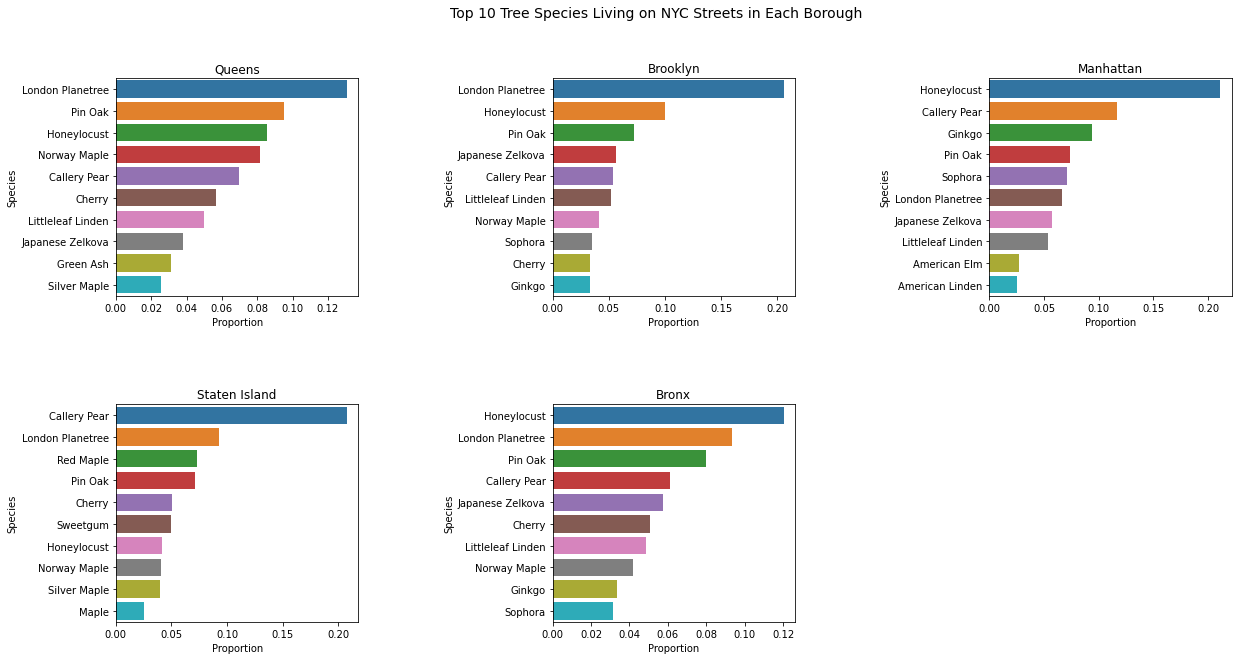

In [11]:
display_top = 10
plt.figure(figsize=(20,10))
plt.suptitle('Top {} Tree Species Living on NYC Streets in Each Borough'.format(display_top), fontsize=14)
for i, b in enumerate(df.borough.unique().tolist()):
    ax=plt.subplot(2, 3, i+1)
    sns.barplot(data=species_counts_boro[i][:display_top].sort_values(by='proportion', ascending=False), x='proportion', y='species', palette='tab10')
    plt.title(b)
    plt.ylabel('Species')
    plt.xlabel('Proportion')
    plt.subplots_adjust(hspace=0.5, wspace=0.8)
# plt.tight_layout()
plt.show()

In [12]:
# print list of all unique tree species (common species names)
print(species_counts.species.to_list())

['London Planetree', 'Honeylocust', 'Callery Pear', 'Pin Oak', 'Norway Maple', 'Littleleaf Linden', 'Cherry', 'Japanese Zelkova', 'Ginkgo', 'Sophora', 'Red Maple', 'Green Ash', 'American Linden', 'Silver Maple', 'Sweetgum', 'Northern Red Oak', 'Silver Linden', 'American Elm', 'Maple', 'Purple-Leaf Plum', 'Swamp White Oak', 'Crimson King Maple', 'Chinese Elm', "'Schubert' Chokecherry", 'Japanese Tree Lilac', 'Eastern Redbud', 'Golden Raintree', 'Crab Apple', 'Kentucky Coffeetree', 'Willow Oak', 'Dawn Redwood', 'Hawthorn', 'Sugar Maple', 'Sycamore Maple', 'Ash', 'Hedge Maple', 'Common Hackberry', 'Sawtooth Oak', 'Amur Maackia', 'European Hornbeam', 'Amur Maple', 'Serviceberry', 'Black Locust', 'White Oak', 'English Oak', 'Siberian Elm', 'Flowering Dogwood', 'American Hornbeam', "Schumard'S Oak", 'Scarlet Oak', 'Black Oak', 'Bald Cypress', 'Mulberry', 'Japanese Maple', 'White Ash', 'Eastern Redcedar', 'Horse Chestnut', 'American Hophornbeam', 'Tulip-Poplar', 'Cornelian Cherry', 'Shingle O

#### Analysis

In [13]:
print("There are {} different species of tree living on NYC streets.".format(len(species_counts)))

print("\nThe top {} most common tree species represent {}% of the total NYC street trees population.\n{} species make up the remaining {}% of the tree population.\n".format(
    len(top_species),
    round(top_species.proportion.sum() * 100, 2),
    len(species_counts) - len(top_species),
    round(species_counts[len(top_species):].proportion.sum() * 100, 2)
))

# print overall statistics
print("Overall, the most common species of tree is the {}.\n{}% of all NYC street trees are {}.".format(
        species_counts.species[0],
        round(species_counts.proportion[0] * 100, 2),
        species_counts.species[0]
    ))
# print remaining top overall statistitcs
for i in range(1,10):
    print("{}% are {}".format(
        round(species_counts.proportion[i] * 100, 2),
        species_counts.species[i]
    ))

# print statistics for each borough
for e, b in enumerate(df.borough.unique().tolist()):
    # print top statistic for borough
    print("\nIn the borough of {}, the most common species of tree is the {}.\n{}% of all NYC street trees in {} are {}.".format(
        b,
        species_counts_boro[e].species[0],
        round(species_counts_boro[e].proportion[0] * 100, 2),
        b,
        species_counts_boro[e].species[0]
    ))
    # print remaining statistics for borough
    for i in range(1,10):
        print("{}% are {}".format(
            round(species_counts_boro[e].proportion[i] * 100, 2),
            species_counts_boro[e].species[i]
        ))

There are 132 different species of tree living on NYC streets.

The top 10 most common tree species represent 65.35% of the total NYC street trees population.
122 species make up the remaining 34.65% of the tree population.

Overall, the most common species of tree is the London Planetree.
13.34% of all NYC street trees are London Planetree.
9.85% are Honeylocust
9.04% are Callery Pear
8.16% are Pin Oak
5.24% are Norway Maple
4.56% are Littleleaf Linden
4.49% are Cherry
4.49% are Japanese Zelkova
3.22% are Ginkgo
2.97% are Sophora

In the borough of Queens, the most common species of tree is the London Planetree.
13.07% of all NYC street trees in Queens are London Planetree.
9.5% are Pin Oak
8.53% are Honeylocust
8.16% are Norway Maple
6.95% are Callery Pear
5.67% are Cherry
5.0% are Littleleaf Linden
3.78% are Japanese Zelkova
3.11% are Green Ash
2.57% are Silver Maple

In the borough of Brooklyn, the most common species of tree is the London Planetree.
20.55% of all NYC street trees 

#### Conclusions

London Planetree is the most common tree species living on NYC streets followed by Honeylocust, Pin Oak, and Callery Pear. In two of the five boroughs, London Planetree is the most common species. In Queens, 13% of all street trees are London Planetree. The highest concentration of London Planetree is in Brooklyn where it makes up 20% of all trees. In both Manhattan and the Bronx, the most common tree species is Honeylocust making up 21% and 12% of street tree population respectively. In the borough of Staten Island, 20% of street trees are Callery Pear making it the borough's most common species of street tree. In all five NYC boroughs 7% to 9% of street trees are Pin Oak. Though Pin Oak is not the most common tree species in any of the five boroughs, it consistently ranks in the top four.

### Tree Health
What is the health of trees on NYC streets?

#### Method
Let's plot bar charts that visualizes the health of all NYC street trees, health of trees by borough, and health of trees by species. First we'll investigate the `status` variable to check how many trees are alive, dead, or a stump. Then we'll consider the `health` variable for those trees that are alive and plot the results.

In [14]:
# value counts for status of top 10 species
top_species_status = df[df.spc_common.isin(list(top_species.species))].status.value_counts(dropna=False)
top_species_status

Alive    426223
Dead          1
Name: status, dtype: int64

In [15]:
# normalized value counts for status of all trees
status_counts = df.status.value_counts(normalize=True)
status_counts

Alive    0.953765
Stump    0.025818
Dead     0.020417
Name: status, dtype: float64

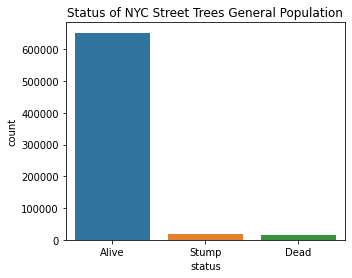

In [16]:
plt.figure(figsize=(5,4))
sns.countplot(data=df, x='status')
plt.title('Status of NYC Street Trees General Population')
plt.show()

In [17]:
# normalized value counts for health of all trees
health_counts = df[df.status=='Alive'].health.value_counts(normalize=True, dropna=True)
health_counts

Good    0.810906
Fair    0.147973
Poor    0.041121
Name: health, dtype: float64

In [18]:
# normalized value counts for health of all trees by borough
health_counts_boro = df[df.status=='Alive'].groupby('borough')['health'].value_counts(normalize=True).unstack().sort_values(by='Good')
health_counts_boro

health             Fair      Good      Poor
borough                                    
Manhattan      0.183574  0.758614  0.057812
Brooklyn       0.147711  0.814238  0.038051
Staten Island  0.143284  0.814939  0.041778
Queens         0.145180  0.815249  0.039572
Bronx          0.135100  0.826494  0.038407

In [19]:
# normalized value counts for health of all trees by top most common species
health_counts_top_species = df[((df.status=='Alive')&(df.spc_common.isin(list(top_species.species))))].groupby('spc_common')['health'].value_counts(normalize=True).unstack().sort_values(by='Good')
health_counts_top_species

health                 Fair      Good      Poor
spc_common                                     
Norway Maple       0.267981  0.621486  0.110533
Littleleaf Linden  0.149284  0.792885  0.057831
Ginkgo             0.132230  0.814593  0.053177
Callery Pear       0.148801  0.815751  0.035448
Sophora            0.149447  0.818699  0.031854
Cherry             0.117764  0.837665  0.044571
London Planetree   0.132220  0.842520  0.025260
Honeylocust        0.133389  0.848093  0.018518
Pin Oak            0.120222  0.856557  0.023221
Japanese Zelkova   0.109064  0.864208  0.026728

In [20]:
# make a copy of the data where tree status is alive and drop na values
data_alive = df[df.status=='Alive'].dropna().copy()
# change the health variable type to categorical and order by value counts
data_alive['health'] = pd.Categorical(data_alive['health'], data_alive.health.value_counts().index.tolist())
data_alive.head()

tree_dbh status health       spc_common   borough   latitude  longitude
0         3  Alive   Fair        Red Maple    Queens  40.723092 -73.844215
1        21  Alive   Fair          Pin Oak    Queens  40.794111 -73.818679
2         3  Alive   Good      Honeylocust  Brooklyn  40.717581 -73.936608
3        10  Alive   Good      Honeylocust  Brooklyn  40.713537 -73.934456
4        21  Alive   Good  American Linden  Brooklyn  40.666778 -73.975979

In [21]:
data_alive.health.value_counts()

Good    528846
Fair     96504
Poor     26817
Name: health, dtype: int64

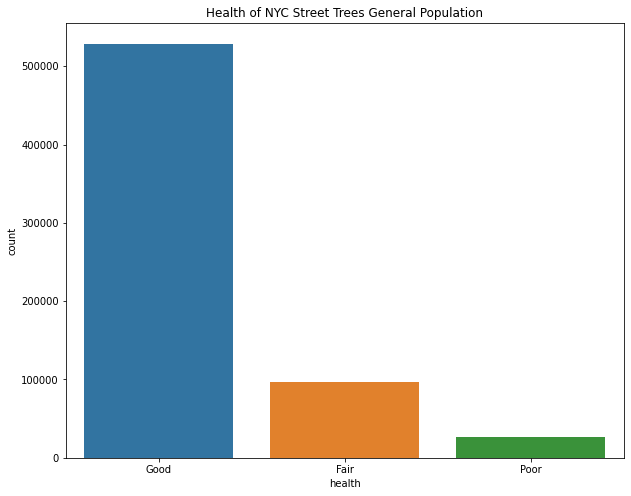

In [22]:
plt.figure(figsize=(10,8))
sns.countplot(
    data=data_alive,
    x='health'
)
plt.title('Health of NYC Street Trees General Population')
plt.show()

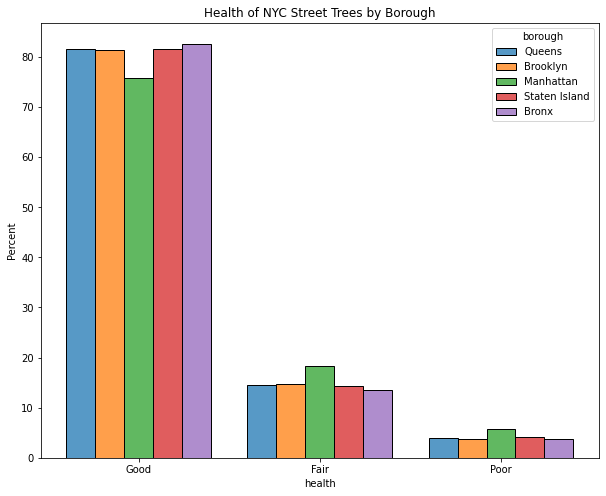

In [23]:
plt.figure(figsize=(10,8))
sns.histplot(data=data_alive, x='health', hue='borough', multiple='dodge', stat='percent', shrink=0.8, common_norm=False)
plt.title('Health of NYC Street Trees by Borough')
plt.show()

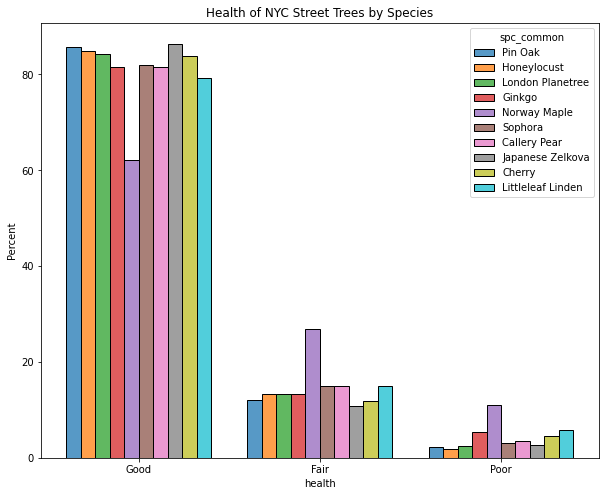

In [24]:
plt.figure(figsize=(10,8))
sns.histplot(data=data_alive[data_alive.spc_common.isin(list(top_species.species))], x='health', hue='spc_common', multiple='dodge', stat='percent', shrink=0.8, common_norm=False)
plt.title('Health of NYC Street Trees by Species')
plt.show()

#### Analysis

In [25]:
print("{}% of all trees in the general population are {}, {}% are a {}, and {}% are {}.".format(
    round(status_counts[0] * 100, 2),
    status_counts.index[0].lower(),
    round(status_counts[1] * 100, 2),
    status_counts.index[1].lower(),
    round(status_counts[2] * 100, 2),
    status_counts.index[2].lower()
))
print("{}% of trees in the general population that are alive are in {} health, {}% are in {} health, and {}% are in {} health.\n".format(
    round(health_counts[0] * 100, 2),
    health_counts.index[0].lower(),
    round(health_counts[1] * 100, 2),
    health_counts.index[1].lower(),
    round(health_counts[2] * 100, 2),
    health_counts.index[2].lower()
))
print("In {}, the percent of trees in {} health is below average. {}% of trees in {} are in {} health, {}% below the average.\n".format(
    health_counts_boro.index[0],
    health_counts_boro.columns[1].lower(),
    round(health_counts_boro.Good[0] * 100, 2),
    health_counts_boro.index[0],
    health_counts_boro.columns[1].lower(),
    round((health_counts[0] - health_counts_boro.Good[0]) * 100, 2)
))
print("The health of trees in the {} is slightly above average. {}% of trees in {} are in {} health, {}% above the average.\n".format(
    health_counts_boro.index[-1],
    round(health_counts_boro.Good[-1] * 100, 2),
    health_counts_boro.index[-1],
    health_counts_boro.columns[1].lower(),
    round(abs(health_counts[0] - health_counts_boro.Good[-1]) * 100, 2)
))
print("In the remaining three boroughs, the percent of trees in {} health is nearly the same as the overall average ({}%).\n{}% of trees in {} are in {} health, {}% in {}, and {}% in {}.".format(
    health_counts_boro.columns[1].lower(),
    round(health_counts[0] * 100, 2),
    round(health_counts_boro.Good[1] * 100, 2),
    health_counts_boro.index[1],
    health_counts_boro.columns[1].lower(),
    round(health_counts_boro.Good[2] * 100, 2),
    health_counts_boro.index[2],
    round(health_counts_boro.Good[3] * 100, 2),
    health_counts_boro.index[3]
))
print("\nAmong the population of the top {} most common tree species, {} trees are {} and {} are {}.\n".format(
    len(top_species),
    top_species_status[0],
    top_species_status.index[0].lower(),
    top_species_status[1],
    top_species_status.index[1].lower()
))
print("Of the top {} most common tree species, {} is the species with the lowest percent of trees in {} health.\nOnly {}% of {} are in {} health, {}% below the average.".format(
    len(top_species),
    health_counts_top_species.index[0],
    health_counts_top_species.columns[1].lower(),
    round(health_counts_top_species.Good[0] * 100, 2),
    health_counts_top_species.index[0],
    health_counts_top_species.columns[1].lower(),
    round(abs(health_counts[0] - health_counts_top_species.Good[0]) * 100, 2)
))

95.38% of all trees in the general population are alive, 2.58% are a stump, and 2.04% are dead.
81.09% of trees in the general population that are alive are in good health, 14.8% are in fair health, and 4.11% are in poor health.

In Manhattan, the percent of trees in good health is below average. 75.86% of trees in Manhattan are in good health, 5.23% below the average.

The health of trees in the Bronx is slightly above average. 82.65% of trees in Bronx are in good health, 1.56% above the average.

In the remaining three boroughs, the percent of trees in good health is nearly the same as the overall average (81.09%).
81.42% of trees in Brooklyn are in good health, 81.49% in Staten Island, and 81.52% in Queens.

Among the population of the top 10 most common tree species, 426223 trees are alive and 1 are dead.

Of the top 10 most common tree species, Norway Maple is the species with the lowest percent of trees in good health.
Only 62.15% of Norway Maple are in good health, 18.94% below 

#### Conclusions

We can see that the majorty of NYC street trees are in good health. Of the five boroughs, Manhattan has the lowest percentage of trees in good health. The percentage of trees in good health is nearly the same in the remaining four boroughs, with the Bronx having the highest by a small margin. When looking at the top 10 most common tree species, Norway Maple is clearly the tree species with the poorest health.

### Tree Diameter
How big are trees on NYC streets? 
#### Method
Let's calculate the average diameter of tree species and plot a boxplot to visualize the range of tree diameter among species. For the analysis we'll use the `tree_dbh` variable which is the tree diameter measured at approximately 54 inches above the ground. Users originally measured tree circumference in the field and divided by 3.14159 to transform it to diameter rounded to the nearest whole inch. We'll start by calculating the average diameter for the top most common tree species.

In [26]:
# calculate mean tree diameter by species using pandas groupby
top_species_diameter = df[df.spc_common.isin(list(top_species.species))].groupby('spc_common')['tree_dbh'].mean().sort_values(ascending=False)
top_species_diameter

spc_common
London Planetree     21.560657
Pin Oak              16.867707
Norway Maple         14.330516
Honeylocust          10.210958
Littleleaf Linden    10.045827
Sophora               9.254628
Callery Pear          8.958307
Ginkgo                8.625476
Japanese Zelkova      7.863559
Cherry                5.691041
Name: tree_dbh, dtype: float64

In [27]:
# build a dataframe of statistics that describe the tree diameter by species
top_species_diam_report = pd.DataFrame(index=top_species_diameter.index, columns=['mean', 'var', 'std', '25%', '50%', '75%'])
for i, s in enumerate(top_species_diameter.index):
    top_species_diam_report.iloc[i]['mean'] = df.tree_dbh[df.spc_common==s].mean()
    top_species_diam_report.iloc[i]['var'] = df.tree_dbh[df.spc_common==s].var()
    top_species_diam_report.iloc[i]['std'] = df.tree_dbh[df.spc_common==s].std()
    top_species_diam_report.iloc[i]['25%'] = df.tree_dbh[df.spc_common==s].quantile(0.25)
    top_species_diam_report.iloc[i]['50%'] = df.tree_dbh[df.spc_common==s].quantile(0.5)
    top_species_diam_report.iloc[i]['75%'] = df.tree_dbh[df.spc_common==s].quantile(0.75)
top_species_diam_report

mean         var       std   25%   50%   75%
spc_common                                                          
London Planetree   21.560657   81.958918  9.053116  16.0  22.0  27.0
Pin Oak            16.867707  102.227271  10.11075   8.0  17.0  24.0
Norway Maple       14.330516   35.995413  5.999618  10.0  14.0  18.0
Honeylocust        10.210958    27.01634  5.197724   6.0  10.0  13.0
Littleleaf Linden  10.045827   42.755473  6.538767   5.0   9.0  13.0
Sophora             9.254628   31.575953  5.619248   5.0   8.0  13.0
Callery Pear        8.958307   22.631097  4.757215   6.0   8.0  11.0
Ginkgo              8.625476   31.594492  5.620898   4.0   8.0  12.0
Japanese Zelkova    7.863559   28.063757  5.297524   4.0   6.0  11.0
Cherry              5.691041   16.401706  4.049902   3.0   5.0   7.0

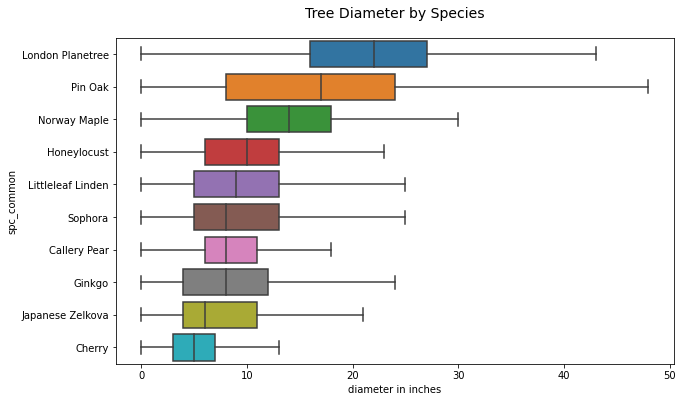

In [28]:
plt.figure(figsize=(10,6))
ax = plt.subplot()
sns.boxplot(data=df[df.spc_common.isin(list(top_species.species))],
            x='tree_dbh',
            y='spc_common',
            order=top_species_diameter.index,
            showfliers=False
           )
plt.xlabel('diameter in inches')
plt.title('Tree Diameter by Species', fontsize=14, pad=20)
plt.show()

#### Analysis

In [29]:
print("Of the top {} most common tree species living on NYC streets, {} has the largest average diameter.\nThe average diameter of {} is {} inches.".format(
    len(top_species_diam_report.index),
    top_species_diam_report.index[0],
    top_species_diam_report.index[0],
    round(top_species_diam_report['mean'][0], 2)
    
))
print("The lower and upper percentiles of {} diameter are {} and {} inches. The median is {} inches.".format(
    top_species_diam_report.index[0],
    round(top_species_diam_report['25%'][0], 2),
    round(top_species_diam_report['75%'][0], 2),
    round(top_species_diam_report['50%'][0], 2)

))
for i, s in enumerate(top_species_diam_report.index[1:]):
    print("{} inches is the average diameter of {} with {} and {} inches the lower and upper percentiles and {} inches the median.".format(
        round(top_species_diam_report['mean'][i+1], 2),
        s,
        round(top_species_diam_report['25%'][i+1], 2),
        round(top_species_diam_report['75%'][i+1], 2),
        round(top_species_diam_report['50%'][i+1], 2)
    ))

Of the top 10 most common tree species living on NYC streets, London Planetree has the largest average diameter.
The average diameter of London Planetree is 21.56 inches.
The lower and upper percentiles of London Planetree diameter are 16.0 and 27.0 inches. The median is 22.0 inches.
16.87 inches is the average diameter of Pin Oak with 8.0 and 24.0 inches the lower and upper percentiles and 17.0 inches the median.
14.33 inches is the average diameter of Norway Maple with 10.0 and 18.0 inches the lower and upper percentiles and 14.0 inches the median.
10.21 inches is the average diameter of Honeylocust with 6.0 and 13.0 inches the lower and upper percentiles and 10.0 inches the median.
10.05 inches is the average diameter of Littleleaf Linden with 5.0 and 13.0 inches the lower and upper percentiles and 9.0 inches the median.
9.25 inches is the average diameter of Sophora with 5.0 and 13.0 inches the lower and upper percentiles and 8.0 inches the median.
8.96 inches is the average diamet

#### Conclusions

Of the top 10 most common tree species living on NYC streets, London Planetree is the tree species with the largest average diameter. Pin Oak is the tree species with the largest range of diameter. In some cases Pin Oak can grow larger than the largest London Planetree. Tree species that tend to be similar in size are: Honeylocust, Littleleaf Linden, Sophora, Callery Pear, Ginkgo, and Japanese Zelkova. Cherry is the smallest tree species of the top 10 most common tree species.

## Data Visualization

### Tree Locations
Where are trees located in the five boroughs?

In this section we'll plot the geolocations of trees on a map within the boundaries of all five NYC boroughs. We'll use the `latitude` and `longitude` variables to plot location markers for individual trees. The `health` variable will control the marker color and `tree_dbh` will influence marker size.

In [30]:
# convert a pandas dataframe to a geo dataframe using geopandas
def create_trees_geodf(variable_name, variable_value, data_frame):
    data = data_frame[data_frame[variable_name]  == variable_value]
    geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
    geo_data_frame = gpd.GeoDataFrame(data, geometry=geometry)
    return geo_data_frame
                                           

In [31]:
# function for plotting geolocation data on nyc borough boundaries map
def plot_geo_data(boundaries, geo_data_frame, boro_names, boro_colors, title, labels, label_variable, legend_title):
    fig = plt.figure(figsize=(15,15))
    ax = plt.subplot()
    shapes = boundaries.plot(ax=ax, alpha=0.3, edgecolor='black', cmap='tab10')
    
    for label, color in labels:
        data = geo_data_frame[geo_data_frame[label_variable]==label]
        marker_size = data.tree_dbh        
        data.plot(ax=ax, markersize=marker_size, alpha=0.3, color=color)
    
    # plt custom legend
    for label, color in labels:
        plt.scatter([], [], c=color, s=200,
                label=str(label))
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title=legend_title)                      
    plt.title(title, fontsize=14, pad=20)
    plt.axis("off")
    plt.show()

In [32]:
# Open shapefiles with NYC Borough boundaries
borough_boundaries = gpd.read_file('../data/nyc_borough_boundaries/geo_export_3d293f59-1915-4dd1-b404-d21636736c21.shp')
borough_boundaries

boro_code      boro_name    shape_area     shape_leng  \
0        4.0         Queens  3.040206e+09  900269.280485   
1        3.0       Brooklyn  1.934167e+09  728477.954082   
2        5.0  Staten Island  1.623631e+09  325924.002076   
3        1.0      Manhattan  6.366208e+08  359993.126318   
4        2.0          Bronx  1.187194e+09  463868.599917   

                                            geometry  
0  MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ...  
1  MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ...  
2  MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...  
3  MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...  
4  MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...

In [33]:
boro_names = borough_boundaries.boro_name.to_list()
boro_colors = ['red', 'green', 'orange', 'blue', 'pink']
dict(list(zip(boro_names, boro_colors)))

{'Queens': 'red',
 'Brooklyn': 'green',
 'Staten Island': 'orange',
 'Manhattan': 'blue',
 'Bronx': 'pink'}

#### Plot Tree Locations
Let's plot the geolocation and health of the top 10 species of NYC street trees.

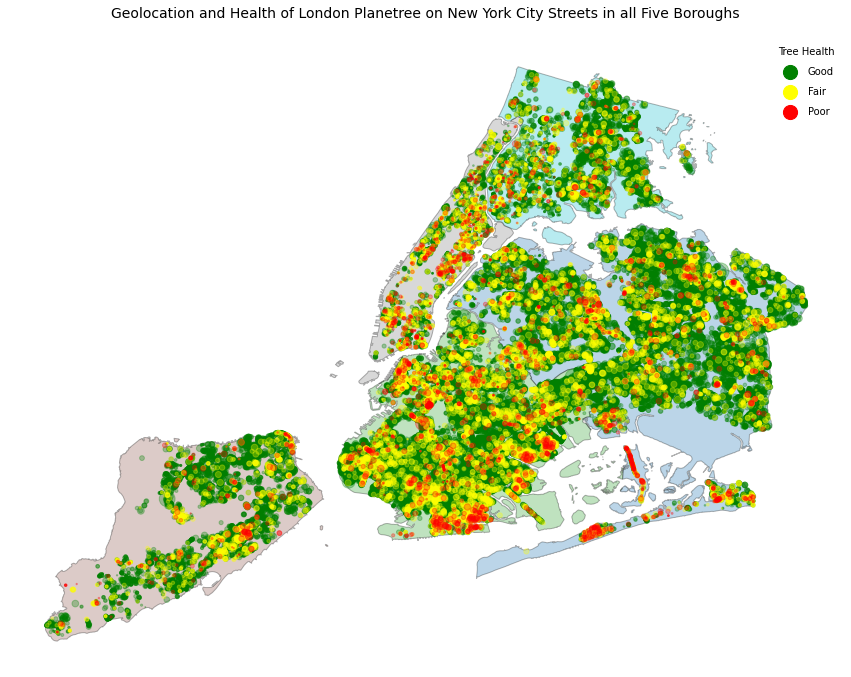

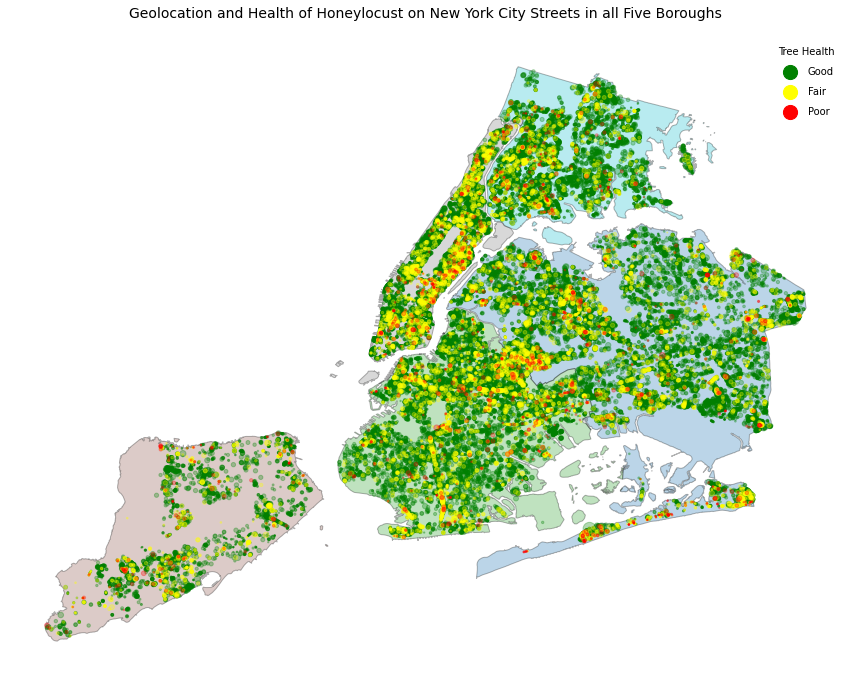

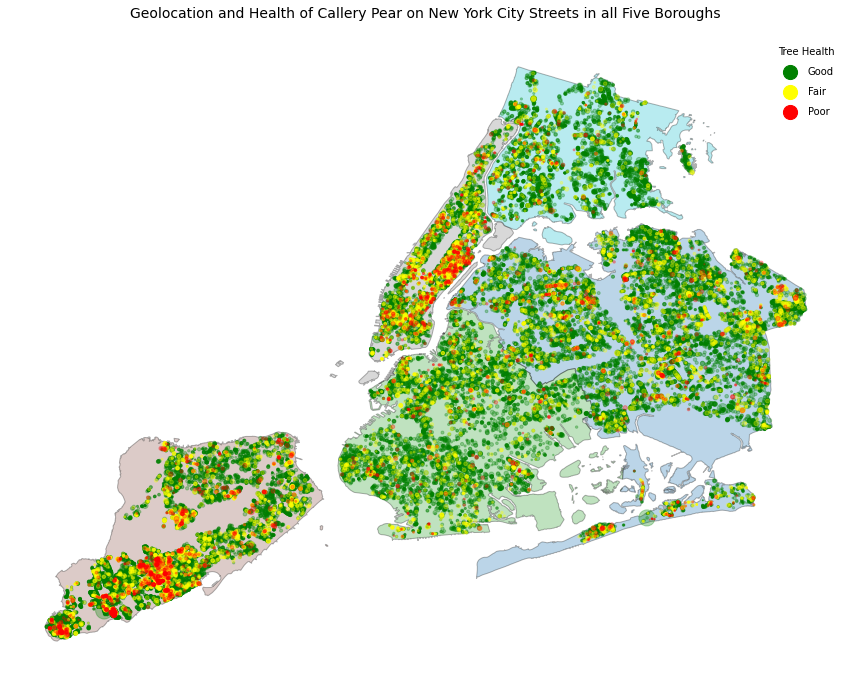

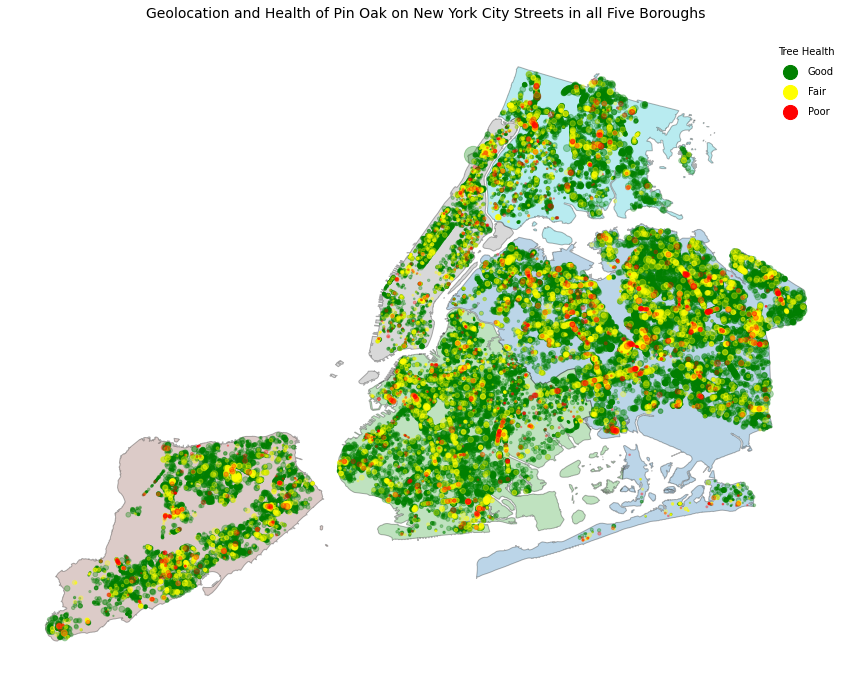

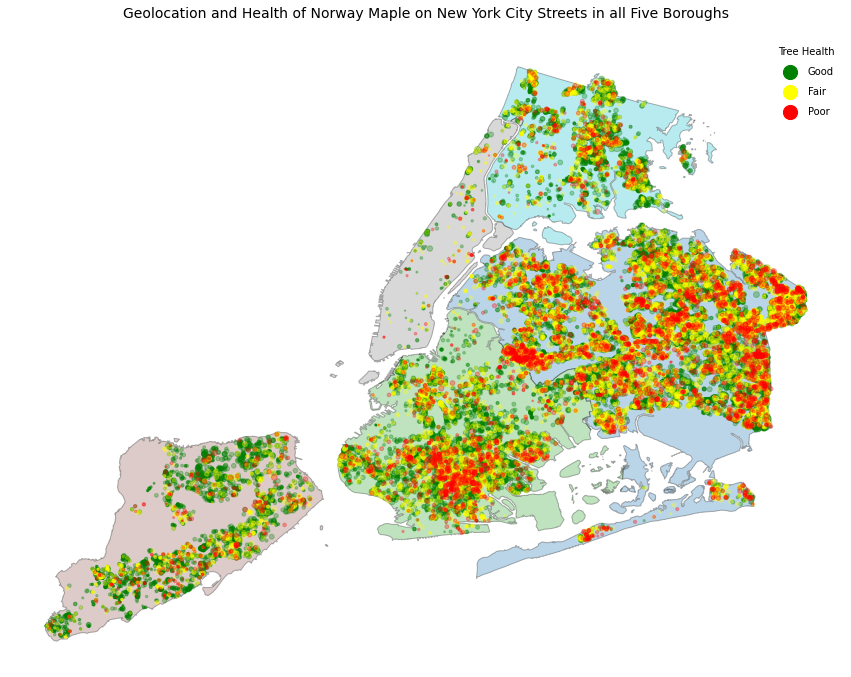

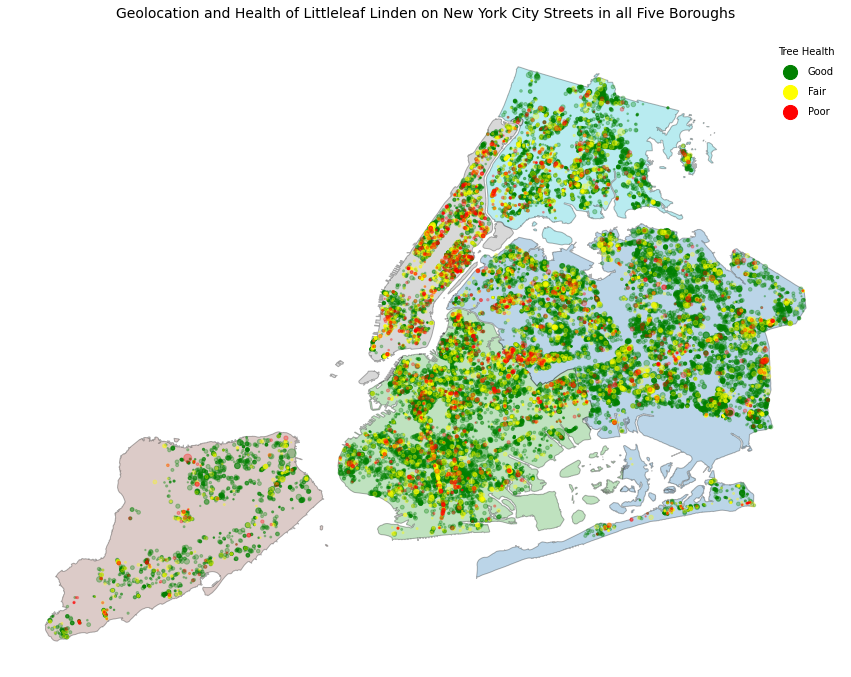

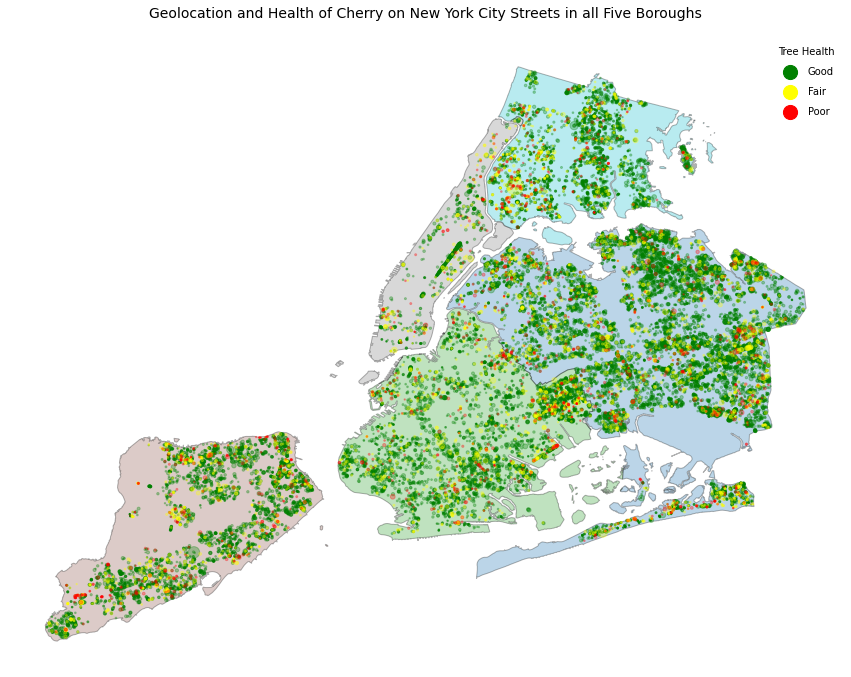

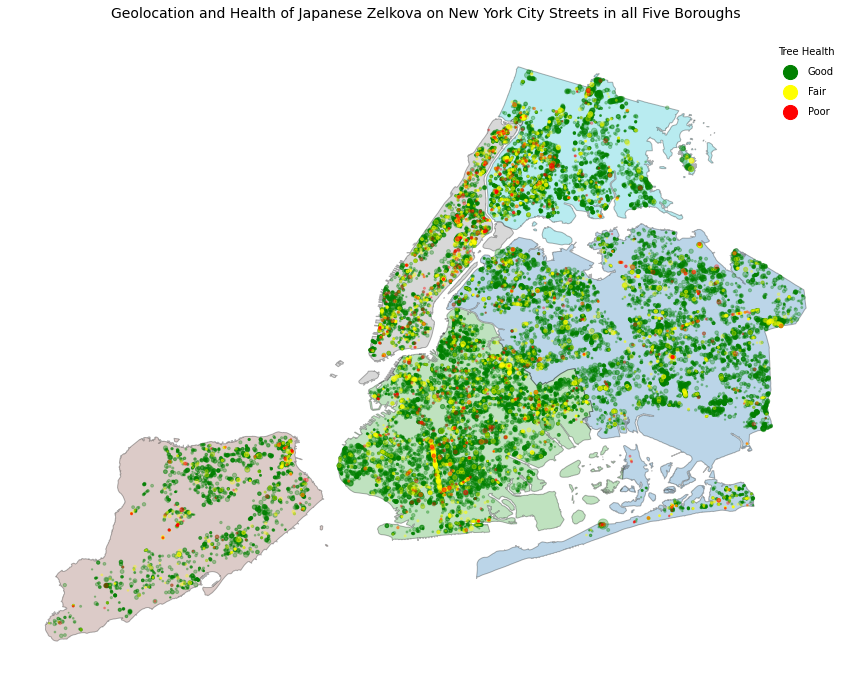

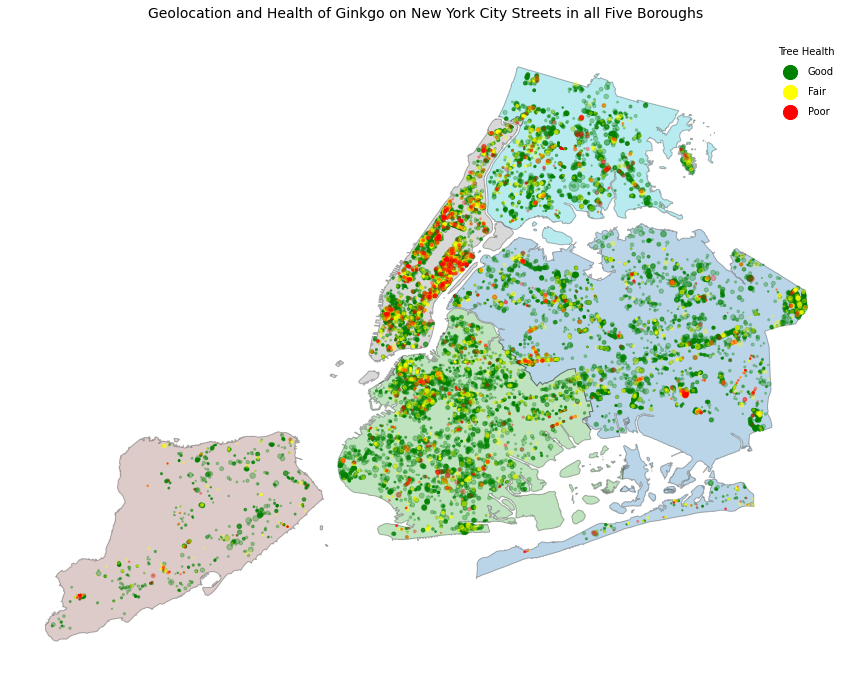

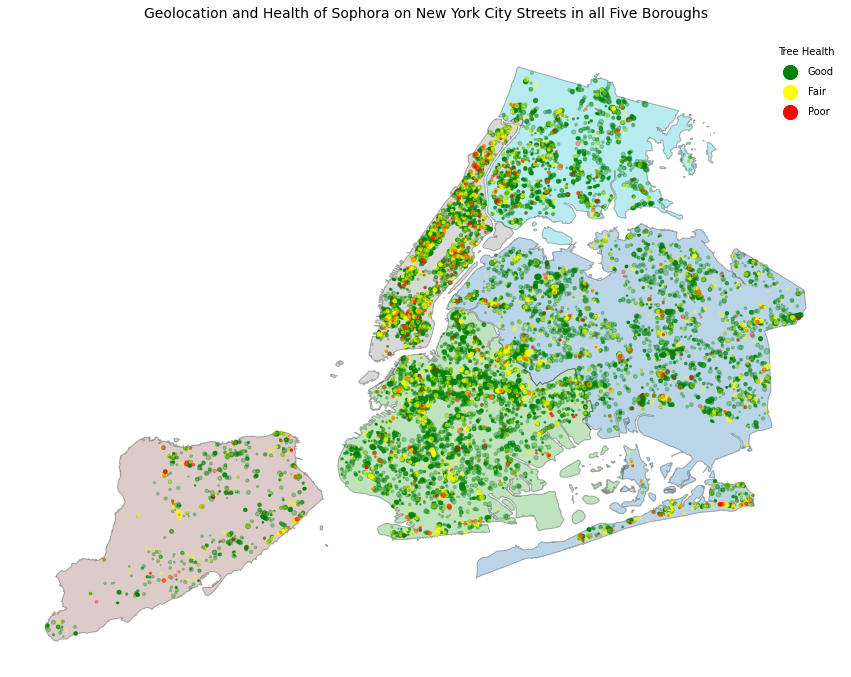

In [34]:
for species in top_species.species:
    plot_geo_data(
        boundaries=borough_boundaries,
        geo_data_frame=create_trees_geodf(
            variable_name='spc_common',
            variable_value=species.title(),
            data_frame=df[['spc_common', 'tree_dbh', 'health', 'longitude', 'latitude']]),
        boro_names=boro_names,
        boro_colors=boro_colors,
        title="Geolocation and Health of {} on New York City Streets in all Five Boroughs".format(species.title()),
        labels = [("Good", "green"), ("Fair", "yellow"), ("Poor", "red")],
        label_variable = 'health',
        legend_title = 'Tree Health'        
    )
